##**Packages**

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import keras
import cv2
import pickle
import sklearn
import scipy

from sklearn.metrics import auc, f1_score, roc_curve, recall_score, precision_score, accuracy_score, confusion_matrix
from sklearn import metrics

from google.colab import files
from keras.preprocessing import image

from keras.layers.serialization import activation
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import Xception
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K
from tensorflow.keras import layers
from keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from tensorflow.keras import applications
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense

!pip install h5py pyyaml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##**Data directory**

In [ ]:
base_dir = '/content/drive/MyDrive/1wholeDatasetTrain&Test'

training_set_dir = os.path.join(base_dir, 'training_set')
test_set_dir = os.path.join(base_dir, 'test_set')

train_lungCancer_dir = os.path.join(training_set_dir, 'lungCancer') 
train_normal_dir = os.path.join(training_set_dir, 'normal')
test_lungCancer_dir = os.path.join(test_set_dir, 'lungCancer')
test_normal_dir = os.path.join(test_set_dir, 'normal')

# print(training_set_dir)

In [ ]:
train_lungCancer_names = os.listdir(train_lungCancer_dir)
print(train_lungCancer_names[:10])

train_normal_names = os.listdir(train_normal_dir)
print(train_normal_names[:10])

['Copy of 0000099 (31).tif', 'Copy of 0000099 (32).tif', 'Copy of 0000099 (37).tif', 'Copy of 0001377 (54).tif', 'Copy of 0000099 (30).tif', 'Copy of 0000099 (35).tif', 'Copy of 0000099 (36).tif', 'Copy of 0000099 (29).tif', 'Copy of 0000099 (34).tif', 'Copy of 0000099 (33).tif']
['Copy of 0000003 (10).tif', 'Copy of 0000003 (14).tif', 'Copy of 0000003 (12).tif', 'Copy of 0000003 (15).tif', 'Copy of 0000003 (18).tif', 'Copy of 0000044 (23).tif', 'Copy of 0000003 (17).tif', 'Copy of 0000003 (11).tif', 'Copy of 0000003 (16).tif', 'Copy of 0000003 (13).tif']


In [ ]:
print('total training lungCancer images:', len(os.listdir(train_lungCancer_dir)))
print('total training normal images:', len(os.listdir(train_normal_dir)))

total training lungCancer images: 596
total training normal images: 601


##**Data generation**

In [ ]:
print(training_set_dir)
print(test_set_dir)

/content/drive/MyDrive/1wholeDatasetTrain&Test/training_set
/content/drive/MyDrive/1wholeDatasetTrain&Test/test_set


In [ ]:
img_width, img_height = 299, 299
batch_size = 60

In [ ]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                  rotation_range= 25,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  zoom_range=0.1,
                                  fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
        training_set_dir,  
        target_size=(img_width, img_height),  
        batch_size=batch_size,
        class_mode='categorical',
        shuffle = True)


test_datagen = ImageDataGenerator(rescale=1.0/255.0)

test_generator = test_datagen.flow_from_directory(
        test_set_dir,  
        target_size=(img_width, img_height),  
        batch_size=batch_size,
        class_mode='categorical')

Found 1197 images belonging to 3 classes.
Found 298 images belonging to 2 classes.


##**defining model**

In [ ]:
pre_trained_model = Xception(include_top=False, 
                                        weights= 'imagenet',
                                        input_shape = (299, 299, 3))
  
for layer in pre_trained_model.layers[0:-6]:
  layer.trainable = False

83683744/83683744 [==============================] - 3s 0us/step


In [ ]:
pre_trained_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [ ]:
last_layer = pre_trained_model.get_layer('block14_sepconv2_act')

print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

x = GlobalAveragePooling2D()(last_output)

x = Flatten()(x)

x = Dense(2, activation='softmax')(x)

model = Model(pre_trained_model.input, x) 

last layer output shape:  (None, 10, 10, 2048)


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

##**defining model callbacks**

In [ ]:
checkpoint_path = os.path.join('/content/drive/MyDrive/copyweights', '1')
checkpoint_dir = os.path.dirname(checkpoint_path)
print(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True, save_best_only=True, verbose= 1)

/content/drive/MyDrive/copyweights/1


In [ ]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=1000, decay_rate=0.4, staircase=True)

##**compiling the model**

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate= lr_schedule), loss='categorical_crossentropy', metrics= [tf.keras.metrics.BinaryAccuracy(name="Binary_accuracy"),
                        tf.keras.metrics.Precision(name='Precision'),
                        tf.keras.metrics.Recall(name='Recall'), 
                        tf.keras.metrics.TruePositives(name='TP'), 
                        tf.keras.metrics.TrueNegatives(name='TN'), 
                        tf.keras.metrics.FalseNegatives(name='FN'), 
                        tf.keras.metrics.FalsePositives(name='FP'),
                        tf.keras.metrics.AUC(name='AUC')])

In [ ]:
history = model.fit(
            train_generator,
            validation_data = test_generator,
            epochs = 20,
            verbose = 1,
            callbacks = [cp_callback])

Epoch 1/20
20/20 [==============================] - ETA: 0s - loss: 0.6848 - Binary_accuracy: 0.5614 - Precision: 0.5614 - Recall: 0.5614 - TP: 672.0000 - TN: 672.0000 - FN: 525.0000 - FP: 525.0000 - AUC: 0.5899 
Epoch 1: val_loss improved from inf to 0.68059, saving model to /content/drive/MyDrive/copyweights/1
20/20 [==============================] - 601s 29s/step - loss: 0.6848 - Binary_accuracy: 0.5614 - Precision: 0.5614 - Recall: 0.5614 - TP: 672.0000 - TN: 672.0000 - FN: 525.0000 - FP: 525.0000 - AUC: 0.5899 - val_loss: 0.6806 - val_Binary_accuracy: 0.5168 - val_Precision: 0.5168 - val_Recall: 0.5168 - val_TP: 154.0000 - val_TN: 154.0000 - val_FN: 144.0000 - val_FP: 144.0000 - val_AUC: 0.6260
Epoch 2/20
20/20 [==============================] - ETA: 0s - loss: 0.6725 - Binary_accuracy: 0.6099 - Precision: 0.6099 - Recall: 0.6099 - TP: 730.0000 - TN: 730.0000 - FN: 467.0000 - FP: 467.0000 - AUC: 0.6676
Epoch 2: val_loss improved from 0.68059 to 0.65064, saving model to /content/dr

##**Loading weights of the model**

In [ ]:
pre_trained_model = Xception(include_top=False, 
                                        weights= 'imagenet',
                                        input_shape = (299, 299, 3))
  
for layer in pre_trained_model.layers[0:-6]:
  layer.trainable = False

In [ ]:
last_layer = pre_trained_model.get_layer('block14_sepconv2_act')

print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

x = GlobalAveragePooling2D()(last_output)

x = Flatten()(x)

x = Dense(2, activation='softmax')(x)

model2 = Model(pre_trained_model.input, x) 

last layer output shape:  (None, 10, 10, 2048)


In [ ]:
checkpoint_path = os.path.join('/content/drive/MyDrive/copyweights', '1')
checkpoint_dir = os.path.dirname(checkpoint_path)
print(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True, save_best_only=True, verbose= 1)

/content/drive/MyDrive/copyweights/1


In [ ]:
model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate= lr_schedule), loss='categorical_crossentropy', metrics= [tf.keras.metrics.BinaryAccuracy(name="Binary_accuracy"),
                        tf.keras.metrics.Precision(name='Precision'),
                        tf.keras.metrics.Recall(name='Recall'), 
                        tf.keras.metrics.TruePositives(name='TP'), 
                        tf.keras.metrics.TrueNegatives(name='TN'), 
                        tf.keras.metrics.FalseNegatives(name='FN'), 
                        tf.keras.metrics.FalsePositives(name='FP'),
                        tf.keras.metrics.AUC(name='AUC')])

In [ ]:
model2.load_weights(checkpoint_path)

In [ ]:
model2.evaluate(test_generator)

5/5 [==============================] - 134s 26s/step - loss: 0.4472 - Binary_accuracy: 0.9195 - Precision: 0.9195 - Recall: 0.9195 - TP: 274.0000 - TN: 274.0000 - FN: 24.0000 - FP: 24.0000 - AUC: 0.9724


[0.44723203778266907,
 0.9194630980491638,
 0.9194630980491638,
 0.9194630980491638,
 274.0,
 274.0,
 24.0,
 24.0,
 0.9723660945892334]

##**CMAP**

In [ ]:
loaded_model = model2
img_width, img_height = 299, 299

##**Heatmap for uploaded PET/CT images from a cloud drive**

1/1 [==============================] - 1s 698ms/step


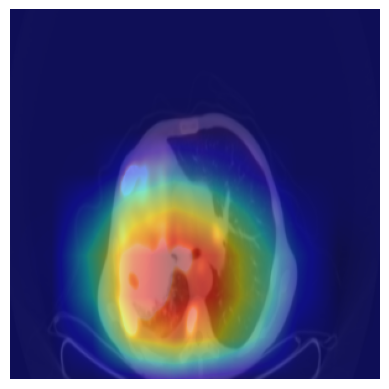

1/1 [==============================] - 0s 477ms/step


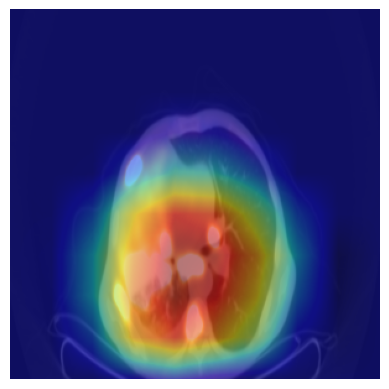

1/1 [==============================] - 0s 389ms/step


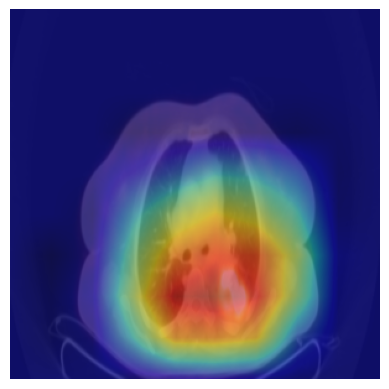

1/1 [==============================] - 0s 384ms/step


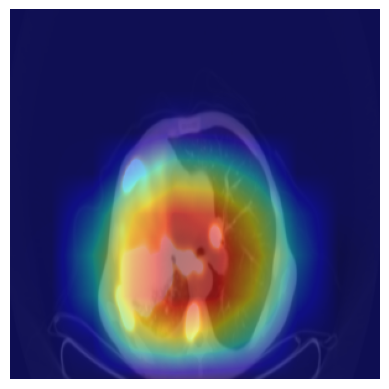

1/1 [==============================] - 0s 380ms/step


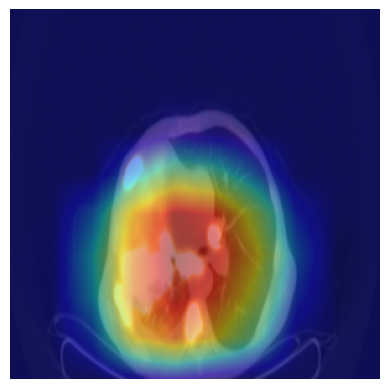

1/1 [==============================] - 0s 394ms/step


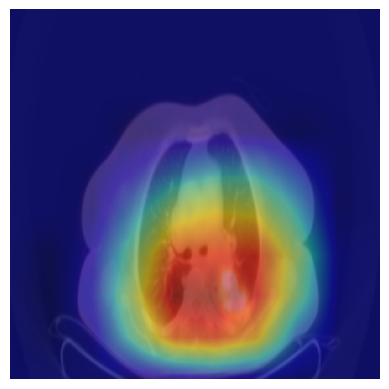

1/1 [==============================] - 0s 376ms/step


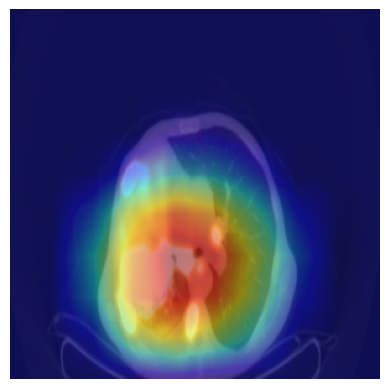

1/1 [==============================] - 0s 385ms/step


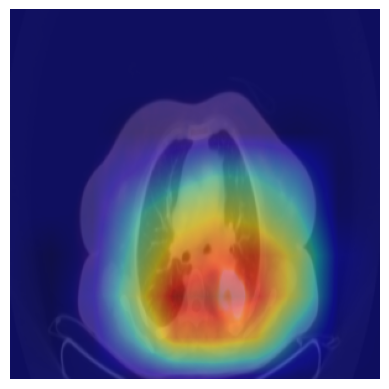

In [ ]:
fileNames = os.listdir('/content/drive/MyDrive/patient1/lungCancer')
filePaths = []


for i in fileNames:
  path = '/content/drive/MyDrive/patient1/lungCancer/'
  new_path = path + i
  filePaths.append(new_path)


for fn in filePaths:
  img = io.imread(fn)
  img = resize(img, (299, 299), anti_aliasing=True)
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_tensor = np.expand_dims(img_array, axis=0)
  predictions = loaded_model.predict(img_tensor)
  label_index = np.argmax(predictions)
  class_weights = loaded_model.layers[-1].get_weights()[0]
  class_weights_winner = class_weights[:, label_index]
  final_conv_layer = loaded_model.get_layer("block14_sepconv2_act")
  get_output = K.function([loaded_model.layers[0].input], [final_conv_layer.output, loaded_model.layers[-1].output])
  [conv_outputs, predictions] = get_output([img_tensor])
  conv_outputs = np.squeeze(conv_outputs)
  mat_for_mult = scipy.ndimage.zoom(conv_outputs, (29.9, 29.9, 1), order=1)
  cam = np.dot(mat_for_mult.reshape((299*299, 2048)), class_weights_winner).reshape(299,299)
  cam = (cam - cam.min()) / (cam.max() - cam.min())
  color_map = plt.cm.jet(cam)
  overlay = color_map[:, :, :3] * 0.9 + img_array 
  overlay[..., :3] /= 2
  fig, ax = plt.subplots()
  ax.imshow(overlay)
  ax.axis('off')
  plt.show()


##**Heatmap for uploaded PET/CT images from local drive**

Saving 0000158 (26).tif to 0000158 (26).tif
1/1 [==============================] - 0s 402ms/step


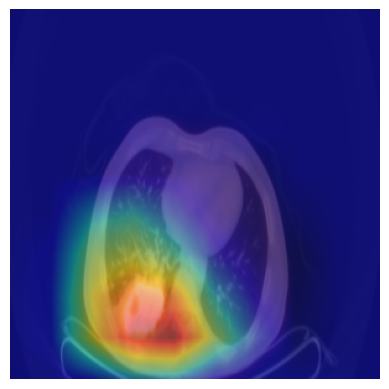

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image


uploaded=files.upload()

for fn in uploaded.keys():
  path='/content/' + fn
  img = io.imread(path)
  img = resize(img, (299, 299), anti_aliasing=True)
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_tensor = np.expand_dims(img_array, axis=0)
  predictions = loaded_model.predict(img_tensor)
  label_index = np.argmax(predictions)
  class_weights = loaded_model.layers[-1].get_weights()[0]
  class_weights_winner = class_weights[:, label_index]
  final_conv_layer = loaded_model.get_layer("block14_sepconv2_act")
  get_output = K.function([loaded_model.layers[0].input], [final_conv_layer.output, loaded_model.layers[-1].output])
  [conv_outputs, predictions] = get_output([img_tensor])
  conv_outputs = np.squeeze(conv_outputs)
  mat_for_mult = scipy.ndimage.zoom(conv_outputs, (29.9, 29.9, 1), order=1)
  cam = np.dot(mat_for_mult.reshape((299*299, 2048)), class_weights_winner).reshape(299,299)
  cam = (cam - cam.min()) / (cam.max() - cam.min())
  color_map = plt.cm.jet(cam)
  overlay = color_map[:, :, :3] * 0.9 + img_array 
  overlay[..., :3] /= 2
  fig, ax = plt.subplots()
  ax.imshow(overlay)
  ax.axis('off')
  plt.show()